# Information about data
This dataset is Surgeries at Borda Technology Hospital require scheduling,in this notebook our aim is to make analysis to the dataset and then create model that is going to predict the duration of each surgery then according to that prediction the hospital would use their resources more efficiently. 

Surgeries at Borda Technology Hospital require scheduling. The hospital has three operating rooms. Surgeons meet to decide the schedule of the surgeries every 2 days. The planning horizon is two days. Surgery times are estimated and used analytical methods. Before planning, each doctor is assigned to the surgery. A doctor cannot be in more than one surgery simultaneously. Also, an operating room can only be used for one surgery at a time. Operating rooms are available between 08:00 AM and 18:00 PM. Cleaning time between surgeries is determined as 15 minutes. The board of directors of Borda Technology Hospital wants to maximize the number of completed surgeries over the planning horizon. Write the mathematical model to solve the problem and explain the constraints used.

## the columns information

#### DiagnosticICD10Code
The ICD-10-CM (International Classification of Diseases, Tenth Revision, Clinical Modification) is a system used by physicians and other healthcare providers to classify and code all diagnoses, symptoms and procedures recorded in conjunction with hospital care in the United States.
#### SurgeryGroup
Indicates risk score of surgery. Risk score decreases from A to E. "0" values can be interpreted as "NULL".
#### AnesthesiaType
There are three types of anesthesia: general, regional, and local. Sometimes, a patient gets more than one type of anesthesia. The type(s) of anesthesia used depends on the surgery or procedure being done and the age and medical conditions of the patient.
####  SurgeryName
Name of surgery
#### Age
Age of patient
#### Sex
Sex of patient
#### Service
Medical department of the hospital
#### DoctorID
Unique id for doctors
#### AnaesthetistID
Unique id for anaesthetist
#### ElapsedTime(second)
Target variable duration of surgeries


# Importing

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu
import tensorflow as tf
%matplotlib inline

# Data reading and showing general information

In [2]:
data=pd.read_csv("train.csv",encoding = "ISO-8859-1")

In [3]:
data.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,ElapsedTime(second)
0,1829,{'L05'},{'C'},Spinal Anestezi,Pilonidal kist,26,MALE,GENEL CERRAH? SERV?S?,5,13,6333
1,1104,{'N20.1'},{'C'},Spinal Anestezi,NaN,24,MALE,ÜROLOJ? SERV?S?,15,3,2972
2,1850,{'K80.8'},{'B'},Genel Anestezi,"Kolelitiazis, di?er",38,MALE,GENEL CERRAH? SERV?S?,36,14,4647
3,1059,"{nan, 'M51.1'}","{0, 'B'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41,FEMALE,ORTOPED? SERV?S?,42,6,4871
4,608,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49,FEMALE,ORTOPED? SERV?S?,42,9,9046


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2822 non-null   int64 
 1   DiagnosticICD10Code  2601 non-null   object
 2   SurgeryGroup         2822 non-null   object
 3   AnesthesiaType       2601 non-null   object
 4   SurgeryName          2447 non-null   object
 5   Age                  2822 non-null   int64 
 6   Sex                  2822 non-null   object
 7   Service              2822 non-null   object
 8   DoctorID             2822 non-null   int64 
 9   AnaesthetistID       2822 non-null   int64 
 10  ElapsedTime(second)  2822 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 242.6+ KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2822.0,1886.876329,1087.423827,2.0,937.25,1900.5,2830.75,3738.0
Age,2822.0,43.897945,16.078510,0.0,34.00,45.0,56.00,102.0
DoctorID,2822.0,30.021616,13.760674,1.0,21.00,32.0,42.00,49.0
AnaesthetistID,2822.0,8.161942,4.400501,1.0,4.00,9.0,12.00,16.0
ElapsedTime(second),2822.0,4542.537916,3034.057882,65.0,2499.50,3732.5,5541.25,21550.0


<AxesSubplot:>

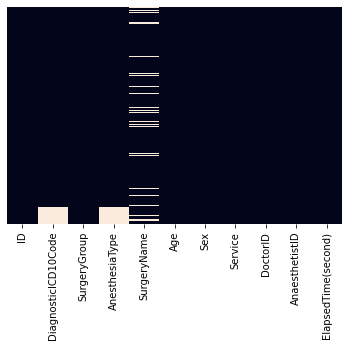

In [6]:
#missing data...
sns.heatmap(pd.isnull(data),cbar=False,yticklabels=False)

In [7]:
data=data.dropna(thresh=2)

In [8]:
#Number of unique values in each column
data.nunique()

ID                     2714
DiagnosticICD10Code     504
SurgeryGroup             36
AnesthesiaType           12
SurgeryName             252
Age                      85
Sex                       2
Service                  10
DoctorID                 48
AnaesthetistID           16
ElapsedTime(second)    2330
dtype: int64

In [9]:
#Correaltion between each column with the target columns
data.corr()["ElapsedTime(second)"]

ID                     0.015791
Age                    0.040832
DoctorID              -0.005492
AnaesthetistID         0.030998
ElapsedTime(second)    1.000000
Name: ElapsedTime(second), dtype: float64

# Data Preprocessing And feature engineering

In [10]:
data["surgery_nn"]=data.groupby("SurgeryName")["ElapsedTime(second)"].transform('mean')
data["surgery_nn"]=data["surgery_nn"].fillna(data["surgery_nn"].mean())

In [11]:
#The general diags lists we are going to use it to categoise the DiagnosticICD10Code  column
diag=["Certain infectious and parasitic diseases","Neoplasms","Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism","Endocrine, nutritional and metabolic diseases","Mental, Behavioral and Neurodevelopmental disorders","Diseases of the nervous system","Diseases of the eye and adnexa","Diseases of the ear and mastoid process","Diseases of the circulatory system","Diseases of the respiratory system","Diseases of the digestive system","Diseases of the skin and subcutaneous tissue","Diseases of the musculoskeletal system and connective tissue","Diseases of the genitourinary system","Pregnancy, childbirth and the puerperium","Certain conditions originating in the perinatal period","Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified","Injury, poisoning and certain other consequences of external causes","Codes for special purposes","External causes of morbidity","Factors influencing health status and contact with health services"]

In [12]:
len(diag)

22

In [13]:
#Data frame their columns is the general diagnostics we are gonna use it to mapping DiagnosticICD10Code columns
diags=pd.DataFrame(columns=diag)

In [14]:
diags

,Certain infectious and parasitic diseases,Neoplasms,Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism,"Endocrine, nutritional and metabolic diseases","Mental, Behavioral and Neurodevelopmental disorders",Diseases of the nervous system,Diseases of the eye and adnexa,Diseases of the ear and mastoid process,Diseases of the circulatory system,Diseases of the respiratory system,...,Diseases of the musculoskeletal system and connective tissue,Diseases of the genitourinary system,"Pregnancy, childbirth and the puerperium",Certain conditions originating in the perinatal period,"Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified","Injury, poisoning and certain other consequences of external causes",Codes for special purposes,External causes of morbidity,Factors influencing health status and contact with health services


In [15]:
new_data=pd.concat([data,diags])

In [16]:
new_data["diag_mum"]=0# Creating a new feature that is gonna be the number of diagnostics of each person

In [17]:
new_data.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,...,Diseases of the genitourinary system,"Pregnancy, childbirth and the puerperium",Certain conditions originating in the perinatal period,"Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified","Injury, poisoning and certain other consequences of external causes",Codes for special purposes,External causes of morbidity,Factors influencing health status and contact with health services,diag_mum
0,1829.0,{'L05'},{'C'},Spinal Anestezi,Pilonidal kist,26.0,MALE,GENEL CERRAH? SERV?S?,5.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1104.0,{'N20.1'},{'C'},Spinal Anestezi,NaN,24.0,MALE,ÜROLOJ? SERV?S?,15.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1850.0,{'K80.8'},{'B'},Genel Anestezi,"Kolelitiazis, di?er",38.0,MALE,GENEL CERRAH? SERV?S?,36.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1059.0,"{nan, 'M51.1'}","{0, 'B'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41.0,FEMALE,ORTOPED? SERV?S?,42.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,608.0,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49.0,FEMALE,ORTOPED? SERV?S?,42.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [18]:
#Function groubed the diagnostics to thier general groups and determined diag_num featuers....
def DiagnosticICD10Code(x):
    z=x
    temp=x["DiagnosticICD10Code"]
    temp=str(temp)[1:-1].replace("'","").split(",")
    x["diag_mum"]=len(temp)
    for i in range(len(temp)):
        if (temp[i].strip()>="A00" and temp[i].strip()<="B99"):
            x["Certain infectious and parasitic diseases"]=1
            
        elif (temp[i].strip()>="C00"and temp[i].strip()<="D49"):
            x["Neoplasms"]=1
            
        elif (temp[i].strip()>="D50" and temp[i].strip()<="D89"):
            x["Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism"]=1
            
        elif (temp[i].strip()>="E00" and temp[i].strip()<="E89"):
            x["Endocrine, nutritional and metabolic diseases"]=1
            
        elif (temp[i].strip()>="F01" and temp[i].strip()<="F99"):
            x["Mental, Behavioral and Neurodevelopmental disorders"]=1
        
        elif (temp[i].strip()>="G00" and temp[i].strip()<="G99"):
            x["Diseases of the nervous system"]=1
            
        elif (temp[i].strip()>="H00"and temp[i].strip()<="H59"):
            x["Diseases of the eye and adnexa"]=1
            
        elif (temp[i].strip()>="H60"and temp[i].strip()<="H95"):
            x["Diseases of the ear and mastoid process"]=1
            
        elif (temp[i].strip()>="I00"and temp[i].strip()<="I99"):
            x["Diseases of the circulatory system"]=1
            
        elif (temp[i].strip()>="J00"and temp[i].strip()<="J99"):
            x["Diseases of the respiratory system"]=1
            
        elif (temp[i].strip()>="K00"and temp[i].strip()<="K95"):
            x["Diseases of the digestive system"]=1
            
        elif (temp[i].strip()>="L00"and temp[i].strip()<="L99"):
            x["Diseases of the skin and subcutaneous tissue"]=1
            
        if (temp[i].strip()>="M00"and temp[i].strip()<="M99"):
            x["Diseases of the musculoskeletal system and connective tissue"]=1
            
        elif (temp[i].strip()>="N00"and temp[i].strip()<="N99"):
            x["Diseases of the genitourinary system"]=1
            
        elif (temp[i].strip()>="O00"and temp[i].strip()<="O9A"):
            x["Pregnancy, childbirth and the puerperium"]=1
            
        elif (temp[i].strip()>="P00"and temp[i].strip()<="P96"):
            x["Certain conditions originating in the perinatal period"]=1
            
        elif (temp[i].strip()>="Q00"and temp[i].strip()<="Q99 "):
            x["Congenital malformations, deformations and chromosomal abnormalities"]=1
            
        elif (temp[i].strip()>="R00"and temp[i].strip()<="R99"):
            x["Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified"]=1
            
        elif (temp[i].strip()>="S00"and temp[i].strip()<="T88"):
            x["Injury, poisoning and certain other consequences of external causes"]=1
            
        elif (temp[i].strip()>="U00"and temp[i].strip()<="U85"):
            x["Codes for special purposes"]=1
            
        elif (temp[i].strip()>="V00"and temp[i].strip()<="Y99"):
            x["External causes of morbidity"]=1
            
        elif (temp[i].strip()>="Z00" and temp[i].strip()<="Z99"):
            x["Factors influencing health status and contact with health services"]=1
    return x
            
        
        

In [19]:
new_data=new_data.apply(DiagnosticICD10Code,axis=1)

In [20]:
new_data[diag]=new_data[diag].fillna(0)

In [21]:
new_data.head()

,ID,DiagnosticICD10Code,SurgeryGroup,AnesthesiaType,SurgeryName,Age,Sex,Service,DoctorID,AnaesthetistID,...,Diseases of the genitourinary system,"Pregnancy, childbirth and the puerperium",Certain conditions originating in the perinatal period,"Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified","Injury, poisoning and certain other consequences of external causes",Codes for special purposes,External causes of morbidity,Factors influencing health status and contact with health services,diag_mum
0,1829.0,{'L05'},{'C'},Spinal Anestezi,Pilonidal kist,26.0,MALE,GENEL CERRAH? SERV?S?,5.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1104.0,{'N20.1'},{'C'},Spinal Anestezi,NaN,24.0,MALE,ÜROLOJ? SERV?S?,15.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1850.0,{'K80.8'},{'B'},Genel Anestezi,"Kolelitiazis, di?er",38.0,MALE,GENEL CERRAH? SERV?S?,36.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1059.0,"{nan, 'M51.1'}","{0, 'B'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,41.0,FEMALE,ORTOPED? SERV?S?,42.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,608.0,"{'M51.1', nan, 'M48.0'}","{0, 'B', 'C', 'D', 'A3'}",Genel Anestezi,Lumbar ve di?er intervertebral disk bozuklukla...,49.0,FEMALE,ORTOPED? SERV?S?,42.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [22]:
#new column which is gonna contain the risk amount of the surgery
new_data["Surgeryrisk"]=0

In [23]:
#this function Determineس the severity of the surgery 
def risk(x):
    temp=x["SurgeryGroup"]
    temp=str(temp)[1:-1].replace("'","").split(",")
    for i in range(len(temp)):
        if temp[i].strip()=='A1':
            x["Surgeryrisk"]=x["Surgeryrisk"]+7
            
        elif (temp[i].strip()=='A2'):
            x["Surgeryrisk"]=x["Surgeryrisk"]+6
            
        elif (temp[i].strip()=='A3'):
            x["Surgeryrisk"]=x["Surgeryrisk"]+5
            
        elif (temp[i].strip()=='B'):
            x["Surgeryrisk"]=x["Surgeryrisk"]+4
            
        elif (temp[i].strip()=='C'):
            x["Surgeryrisk"]=x["Surgeryrisk"]+3
            
        elif (temp[i].strip()=='D'):
            x["Surgeryrisk"]=x["Surgeryrisk"]+2
            
        elif (temp[i].strip()=='E'):
            x["Surgeryrisk"]=x["Surgeryrisk"]+1
            
    return x["Surgeryrisk"]
        
        
        

# Mapping some of feature to determined categories

In [24]:
new_data["Surgeryrisk"]=new_data.apply(risk,axis=1)

In [25]:
maping1={"Genel Anestezi":"Genel Anestezi","Sedo Analjezi":"Sedo Analjezi","Spinal Anestezi":"Spinal Anestezi","Lokal Anestezi":"Lokal Anestezi","Rejyonel Sinir Blo?u":"Others","Epidural ve Genel Anestezi":"Others","Periferik Bloklar":"Others","Epidural Anestezi":"Others","Spinal ve Genel Anestezi":"Others","Seçilmemi?":"Others","Kombine Spinal Epidural Anestezi":"Others","Periferik Bloklar ve Genel Anestezi":"Others"}
maping2={"Ülser veya enflamasyon olmadan alt ekstremitenin variköz venleri":"Ülser veya enflamasyon olmadan alt ekstremitenin variköz venleri","Bilateral inguinal herni, obstrüksiyonsuz veya gangrensiz":"Bilateral inguinal herni, obstrüksiyonsuz veya gangrensiz","Kolelitiazis, di?er":"Kolelitiazis, di?er","Lumbar ve di?er intervertebral disk bozukluklar?, radikülopati ile":"Lumbar ve di?er intervertebral disk bozukluklar?, radikülopati ile","Pilonidal kist":"Pilonidal kist","?nguinal herni":"?nguinal herni","Burnun kazan?lm?? deformitesi":"Burnun kazan?lm?? deformitesi","Eklem a?r?s?":"Eklem a?r?s?","Nazal septum deviasyonu":"Nazal septum deviasyonu","Alt ekstremitenin variköz venleri":"Alt ekstremitenin variköz venleri","Benign prostat hiperplazisi":"Benign prostat hiperplazisi","Gonartroz, tan?mlanmam??":"Gonartroz, tan?mlanmam??","?ntervertebral disk bozukluklar? di?er, tan?mlanmam??":"?ntervertebral disk bozukluklar? di?er, tan?mlanmam??",}
new_data["AnesthesiaType"]=new_data["AnesthesiaType"].map(maping1)
new_data["AnesthesiaType"]=new_data["AnesthesiaType"].fillna("Others_AnesthesiaType")
new_data["SurgeryName"]=new_data["SurgeryName"].map(maping2).fillna("others_SurgeryName")

In [26]:
new_data2=pd.get_dummies(new_data,columns=["AnesthesiaType","Sex","SurgeryName","Service"],drop_first=True)

In [27]:
new_data2=new_data2.drop(["ID","DiagnosticICD10Code","SurgeryGroup"],axis=1)

In [28]:
#summing the value of each group of diagnases to find the values that less than 5 and delete this feature ....
drp=[]
for i in diag:
    print("value    "+str(sum(new_data[i]))+"         column name:          "+i)
    if(sum(new_data[i])<10):
        drp.append(i)

value    5.0         column name:          Certain infectious and parasitic diseases
value    20.0         column name:          Neoplasms
value    5.0         column name:          Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism
value    9.0         column name:          Endocrine, nutritional and metabolic diseases
value    1.0         column name:          Mental, Behavioral and Neurodevelopmental disorders
value    14.0         column name:          Diseases of the nervous system
value    112.0         column name:          Diseases of the eye and adnexa
value    8.0         column name:          Diseases of the ear and mastoid process
value    559.0         column name:          Diseases of the circulatory system
value    133.0         column name:          Diseases of the respiratory system
value    876.0         column name:          Diseases of the digestive system
value    239.0         column name:          Diseases of the s

In [29]:
new_data2=new_data2.drop(columns=drp,axis=1)

In [30]:
 data['ElapsedTime(second)']=(np.round(data['ElapsedTime(second)'] / 15) * 15)/60

In [31]:
new_data2["groupby"]=new_data2.groupby(["Surgeryrisk","diag_mum","Service_ORTOPED? SERV?S?"])['ElapsedTime(second)'].transform('mean')

# General information about Our data after pre.... and feature engineering

In [32]:
new_data2.head()

,Age,DoctorID,AnaesthetistID,ElapsedTime(second),surgery_nn,Neoplasms,Diseases of the nervous system,Diseases of the eye and adnexa,Diseases of the circulatory system,Diseases of the respiratory system,...,Service_GENEL KARMA CERRAH? SERV?S?,Service_GÖZ HASTALIKLARI SERV?S?,Service_KADIN DO?UM SERV?S?,Service_KBB SERV?S?,Service_KVC SERV?S?,Service_NÖRO??RÜRJ? SERV?S?,Service_ORTOPED? SERV?S?,Service_PLAST?K CERRAH?,Service_ÜROLOJ? SERV?S?,groupby
0,26.0,5.0,13.0,6333.0,3045.666667,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,3565.489237
1,24.0,15.0,3.0,2972.0,4511.082550,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,3565.489237
2,38.0,36.0,14.0,4647.0,4418.309524,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,4267.108871
3,41.0,42.0,6.0,4871.0,7990.796296,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,6159.421875
4,49.0,42.0,9.0,9046.0,7990.796296,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,10779.600000


In [33]:
new_data2.shape

(2822, 49)

In [34]:
new_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2822 entries, 0 to 2821
Data columns (total 49 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   Age                                                                                      2822 non-null   float64
 1   DoctorID                                                                                 2822 non-null   float64
 2   AnaesthetistID                                                                           2822 non-null   float64
 3   ElapsedTime(second)                                                                      2822 non-null   float64
 4   surgery_nn                                                                               2822 non-null   float64
 5   Neoplasms                                                     

In [35]:
#Statistical info about data....
new_data2.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2822.0,43.897945,16.078510,0.0,34.000000,45.000000,56.000000,102.000000
DoctorID,2822.0,30.021616,13.760674,1.0,21.000000,32.000000,42.000000,49.000000
AnaesthetistID,2822.0,8.161942,4.400501,1.0,4.000000,9.000000,12.000000,16.000000
ElapsedTime(second),2822.0,4542.537916,3034.057882,65.0,2499.500000,3732.500000,5541.250000,21550.000000
surgery_nn,2822.0,4511.082550,2196.687101,71.5,2781.163636,4409.925439,4511.082550,18281.000000
Neoplasms,2822.0,0.007087,0.083901,0.0,0.000000,0.000000,0.000000,1.000000
Diseases of the nervous system,2822.0,0.004961,0.070272,0.0,0.000000,0.000000,0.000000,1.000000
Diseases of the eye and adnexa,2822.0,0.039688,0.195260,0.0,0.000000,0.000000,0.000000,1.000000
Diseases of the circulatory system,2822.0,0.198086,0.398628,0.0,0.000000,0.000000,0.000000,1.000000
Diseases of the respiratory system,2822.0,0.047130,0.211954,0.0,0.000000,0.000000,0.000000,1.000000


<AxesSubplot:>

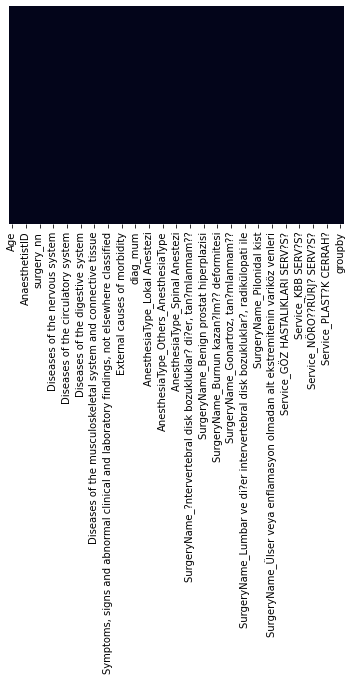

In [36]:
#missing data...
sns.heatmap(pd.isnull(new_data2),cbar=False,yticklabels=False)

# Data analysis and Visualization

In [37]:
binary=[]##spreate the binary and continous values to analys it
continious=[]
for k in new_data2.columns:
    if new_data2[k].nunique()==2:
        binary.append(k)
    else:
        continious.append(k)

In [38]:
print(str("Countinous :")+str(len(continious)))
print(str("binary :")+str(len(binary)))

Countinous :8
binary :41


In [39]:
s=new_data2.corr()['ElapsedTime(second)']##the correlation between the target and features
s=s.sort_values(ascending=False)
s


ElapsedTime(second)                                                                        1.000000
groupby                                                                                    0.756540
surgery_nn                                                                                 0.724010
Surgeryrisk                                                                                0.644376
Diseases of the musculoskeletal system and connective tissue                               0.472736
Service_ORTOPED? SERV?S?                                                                   0.344192
diag_mum                                                                                   0.343675
Service_KBB SERV?S?                                                                        0.271397
SurgeryName_Burnun kazan?lm?? deformitesi                                                  0.267349
Diseases of the respiratory system                                                         0.259627


In [40]:
das={}
def mn(data,cols,target='ElapsedTime(second)'):##function to show the mean value between target and every binary feature...
    for col in cols:
        das[str(col)]=data.groupby(col)[target].mean()[1]
        print(" The mean value of surgery with  "+col+"           "+str(data.groupby(col)[target].mean()[1]))
        print("*********************************")
    return das

In [41]:
das=mn(new_data2,binary)


 The mean value of surgery with  Neoplasms           4450.45
*********************************
 The mean value of surgery with  Diseases of the nervous system           3275.5
*********************************
 The mean value of surgery with  Diseases of the eye and adnexa           3136.526785714286
*********************************
 The mean value of surgery with  Diseases of the circulatory system           3104.066189624329
*********************************
 The mean value of surgery with  Diseases of the respiratory system           8083.872180451128
*********************************
 The mean value of surgery with  Diseases of the digestive system           4435.997716894977
*********************************
 The mean value of surgery with  Diseases of the skin and subcutaneous tissue           4099.397489539749
*********************************
 The mean value of surgery with  Diseases of the musculoskeletal system and connective tissue           7470.4322344322345
*************

<AxesSubplot:title={'center':'the distribution of mean of deuration related to each diags'}, xlabel='diags', ylabel='duration'>

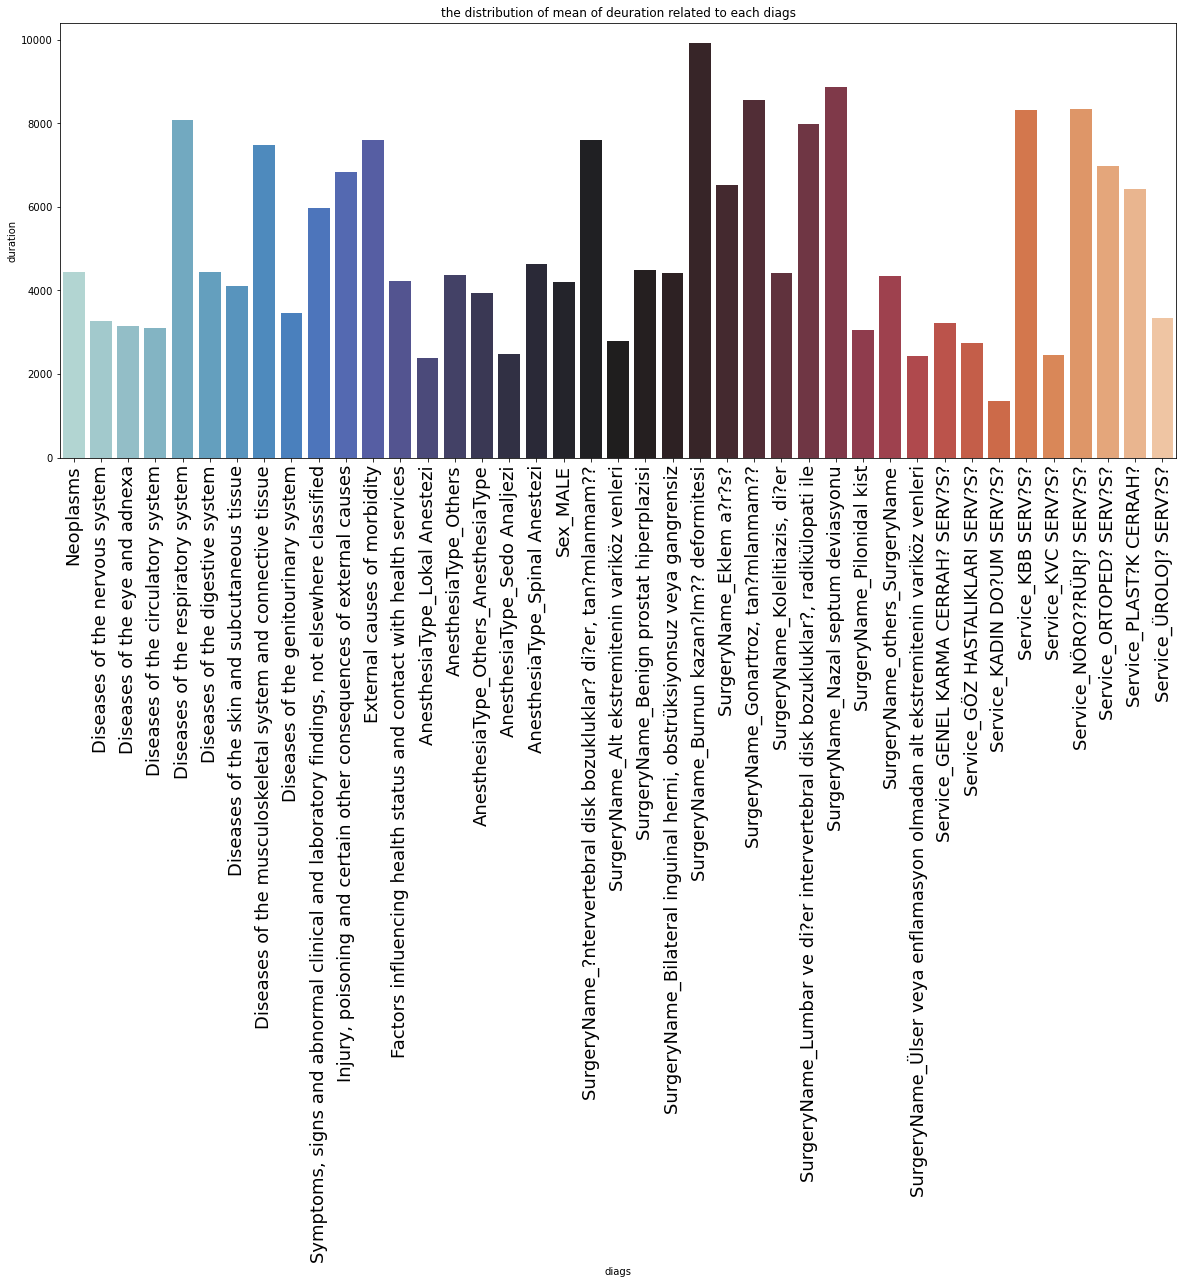

In [42]:
df = pd.DataFrame(list(das.items()), columns=['diags', 'duration'])
plt.figure(figsize=(20,8))
plt.title("the distribution of mean of deuration related to each diags")
plt.ylabel("duration")
plt.ylabel("diags")
plt.xticks(fontsize=18)
plt.xticks(rotation=90)
sns.barplot(x='diags', y='duration', data=df,palette="icefire")

C:\Users\HP\anaconda3\envs\panda_ground\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'the distribution of mean of deuration related to each diags'}, xlabel='duration', ylabel='Density'>

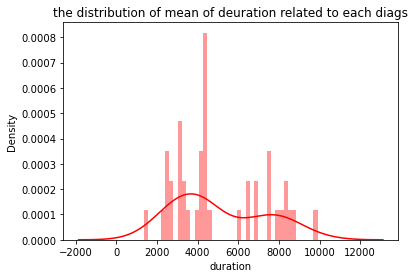

In [43]:
plt.title("the distribution of mean of deuration related to each diags")
sns.distplot(df["duration"],bins=len(df),color="r")

In [44]:
def fd(data,col,target='ElapsedTime(second)'):##function to plot different plots for continous features
    plt.figure(figsize=(20,4))
    plt.subplot(1,3,1)
    plt.title("dist")
    sns.distplot(data[col],bins=30,color = 'r')
 

    plt.subplot(1,3,2)
    plt.title("boxplot")
    plt.xlabel(target)
    plt.xlabel(col)
    sns.boxplot(y=data[col],color = 'g')


    plt.subplot(1,3,3)
    plt.title("scatterplot")
    plt.xlabel(target)
    plt.xlabel(col)
    sns.scatterplot(data[target],data[col],color = 'b')
    
    


In [45]:

continious.remove('ElapsedTime(second)')

C:\Users\HP\anaconda3\envs\panda_ground\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\HP\anaconda3\envs\panda_ground\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\HP\anaconda3\envs\panda_ground\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histpl

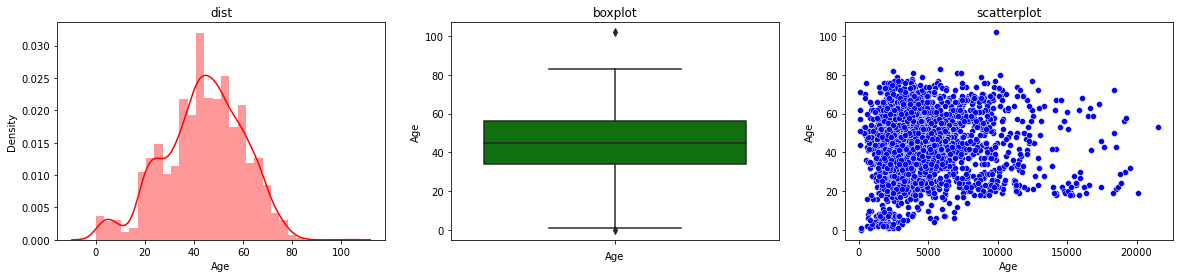

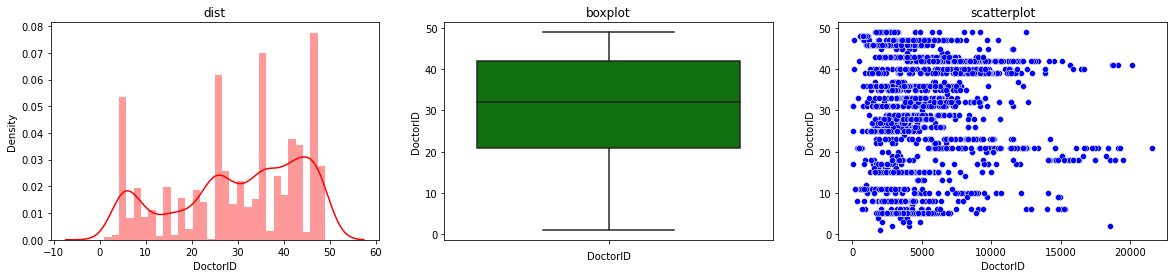

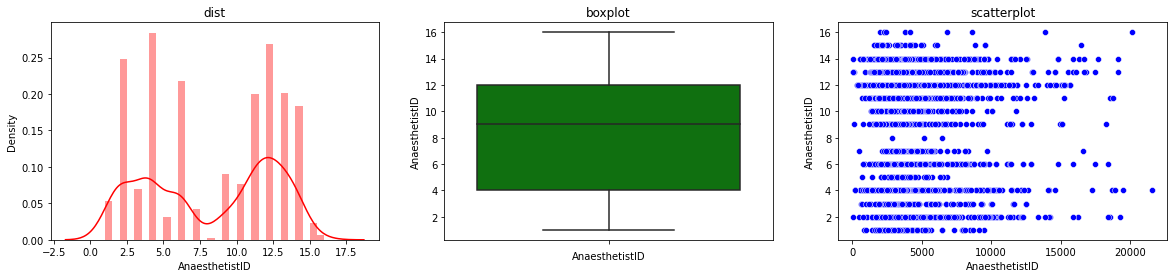

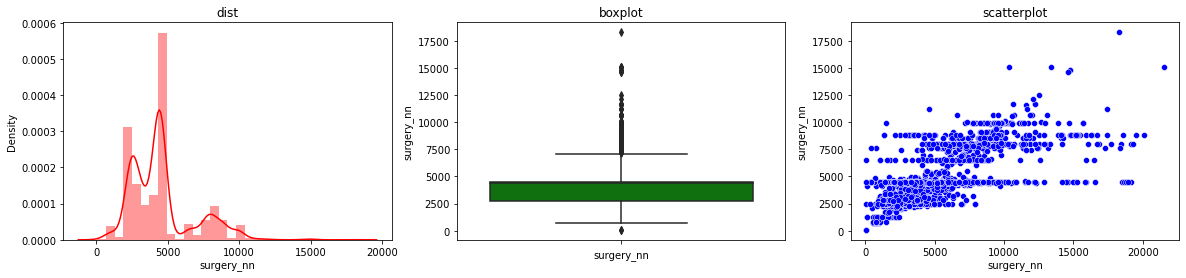

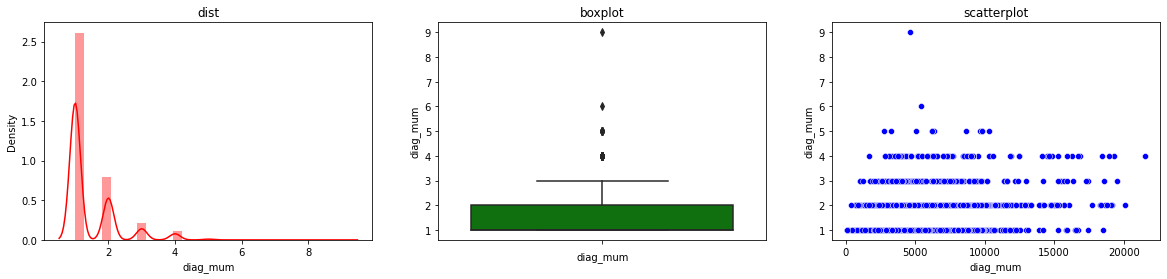

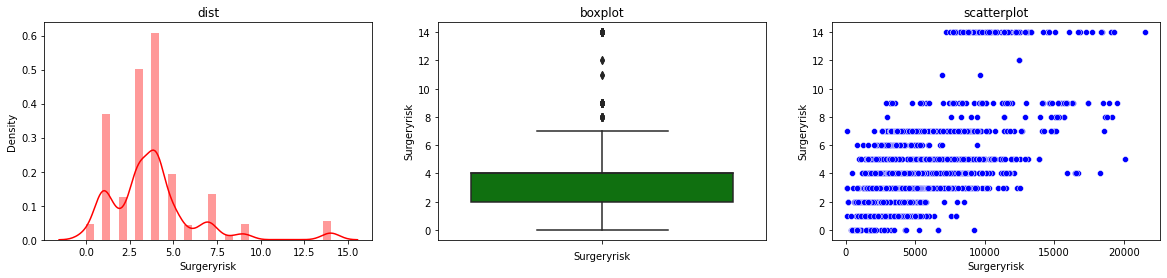

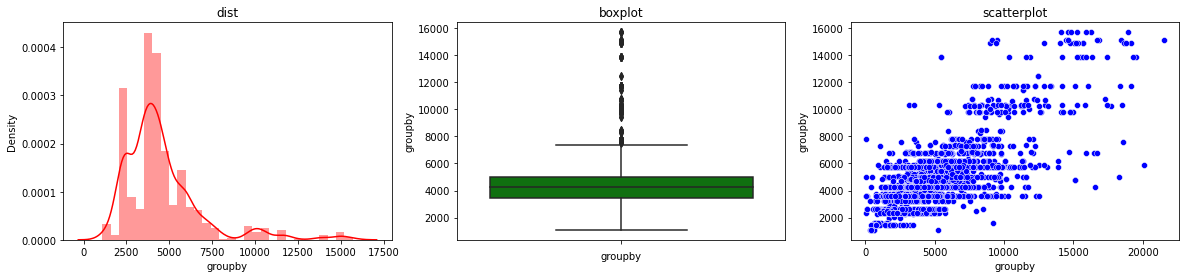

In [46]:
for i in continious:
    fd(new_data2,i)

<AxesSubplot:>

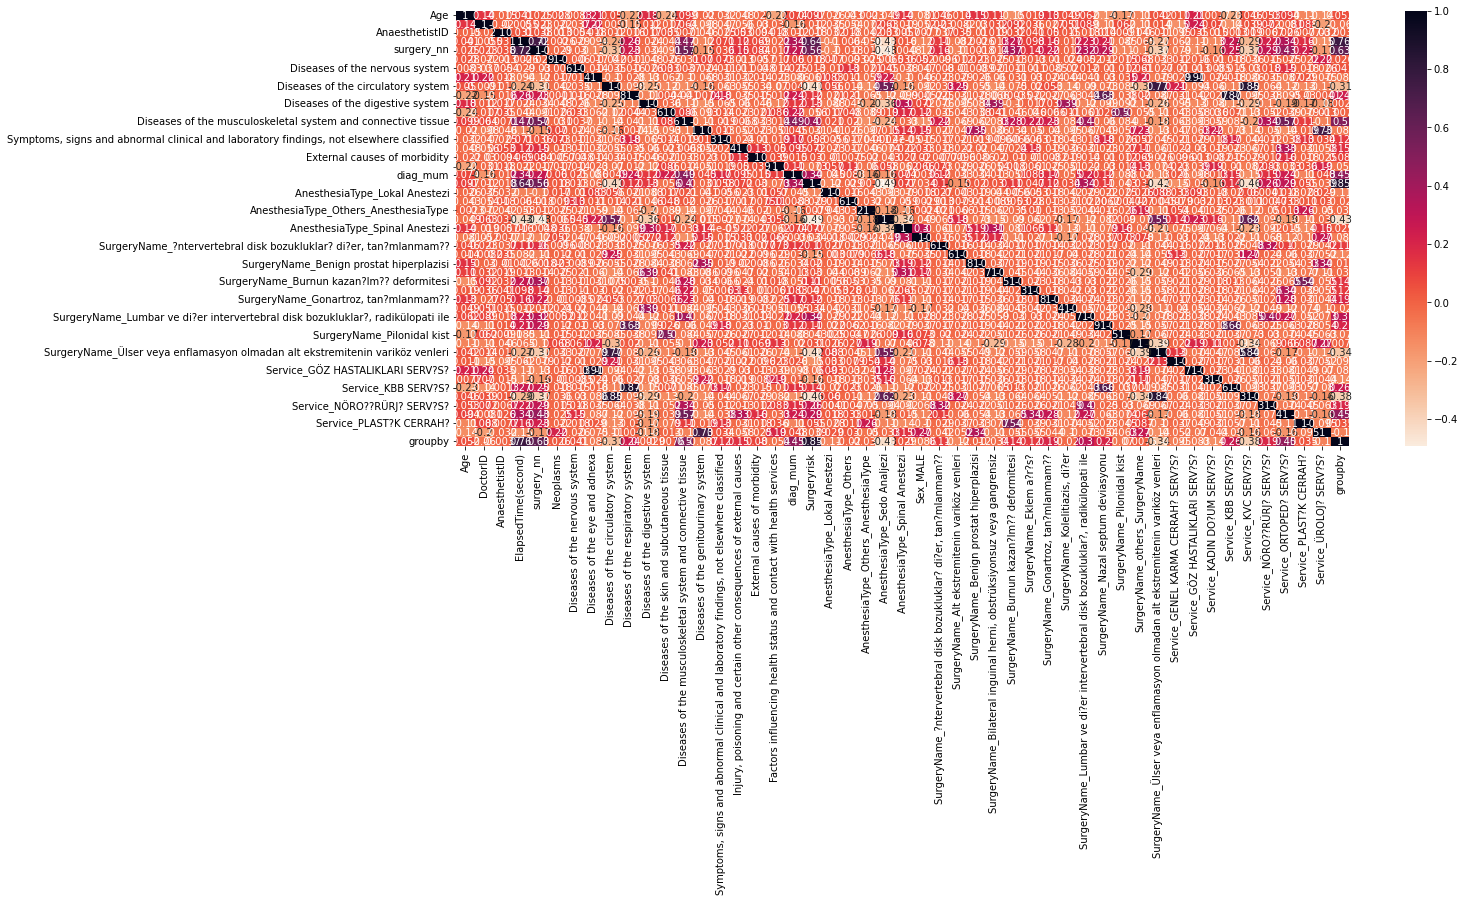

In [47]:
#the correlation between data
plt.figure(figsize=(20,8))
sns.heatmap(new_data2.corr(),annot=True,cmap="rocket_r")

C:\Users\HP\anaconda3\envs\panda_ground\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ElapsedTime(second)', ylabel='Density'>

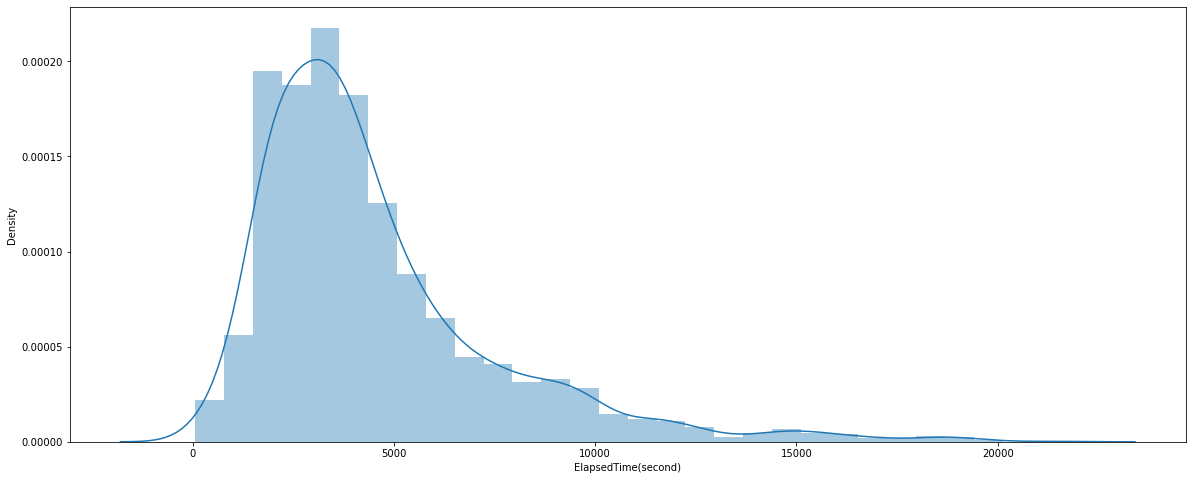

In [48]:
plt.figure(figsize=(20,8))
sns.distplot(new_data2['ElapsedTime(second)'],bins=30)

C:\Users\HP\anaconda3\envs\panda_ground\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'the correlation between the age and ElapsedTime(second)'}, xlabel='ElapsedTime(second)', ylabel='Age'>

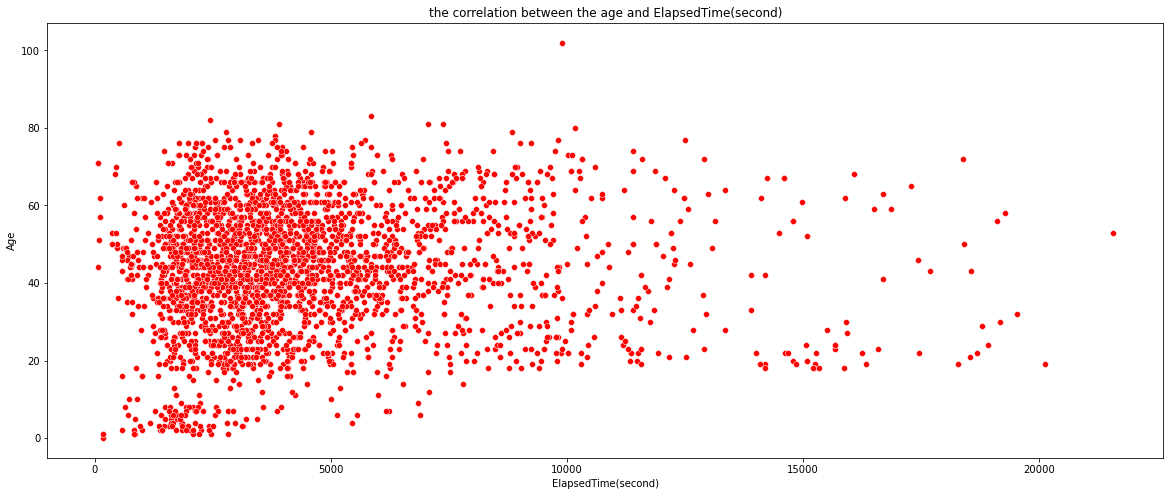

In [49]:
plt.figure(figsize=(20,8))
plt.title("the correlation between the age and ElapsedTime(second)")
sns.scatterplot(new_data2['ElapsedTime(second)'],new_data2['Age'],color='r')

<Figure size 1440x576 with 0 Axes>

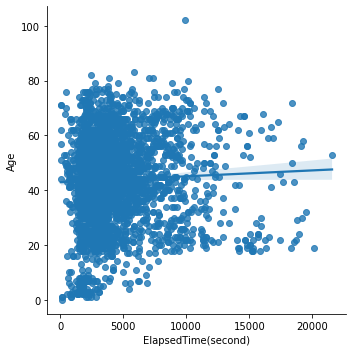

In [50]:
plt.figure(figsize=(20,8))

sns.lmplot(data=new_data2,x='ElapsedTime(second)',y='Age')

<AxesSubplot:xlabel='ElapsedTime(second)', ylabel='Age'>

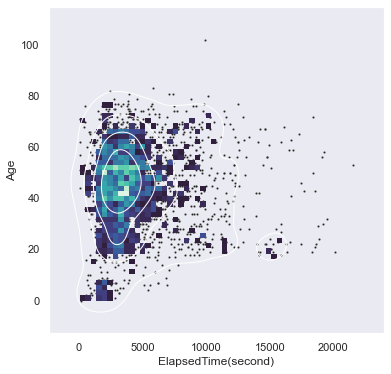

In [51]:
sns.set_theme(style="dark")

# Simulate data from a bivariate Gaussian
n = 10000
mean = [0, 0]
cov = [(2, .4), (.4, .2)]
rng = np.random.RandomState(0)
x, y = new_data2["ElapsedTime(second)"],new_data2["Age"]

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

C:\Users\HP\anaconda3\envs\panda_ground\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\HP\anaconda3\envs\panda_ground\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\HP\anaconda3\envs\panda_ground\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

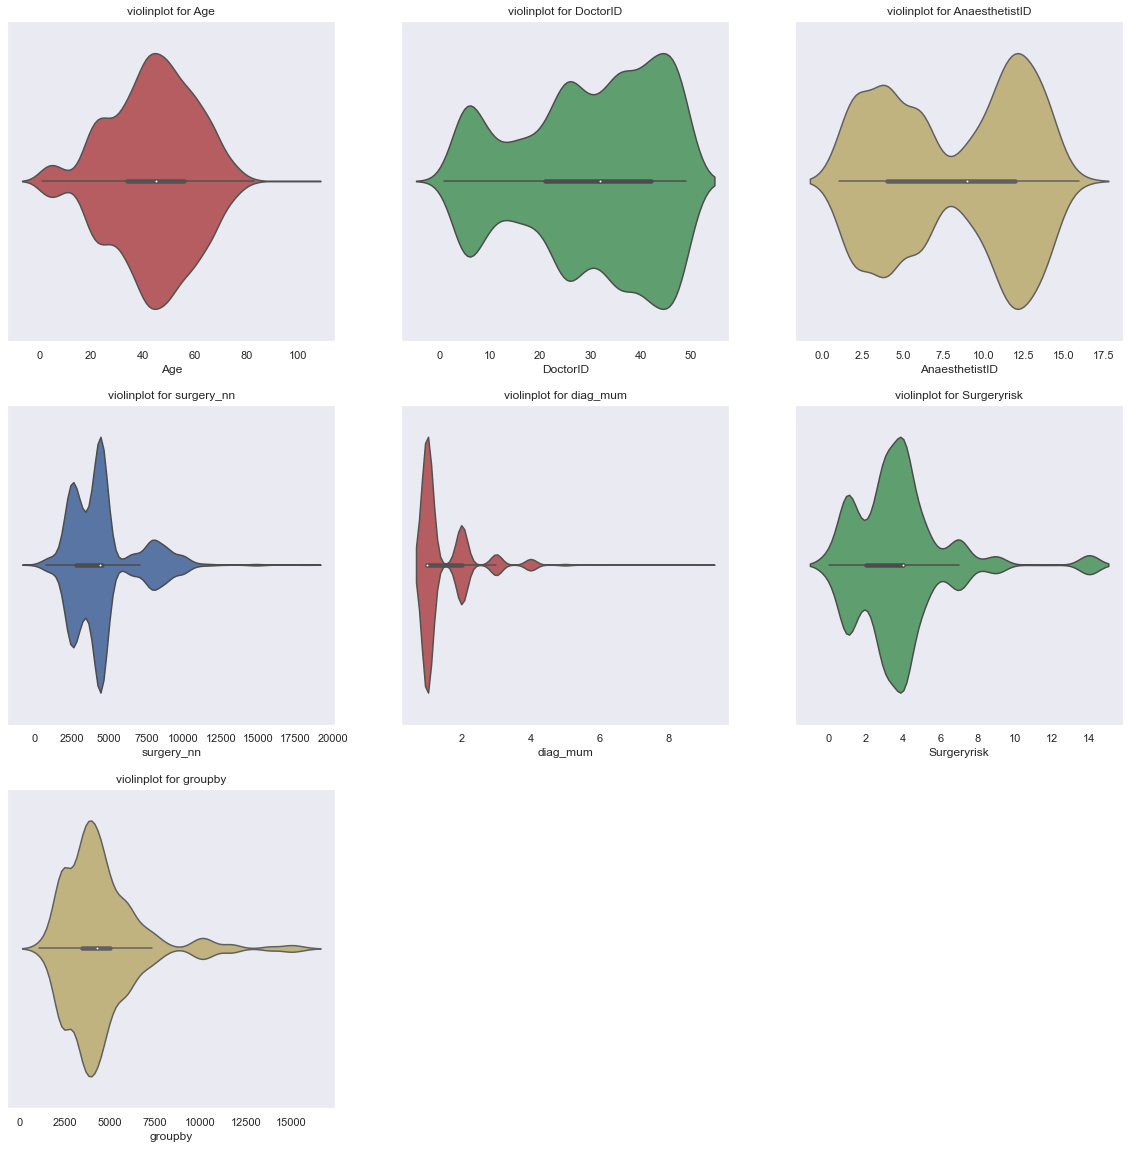

In [52]:
c=1
z=[0,"r","g","y","b","r","g","y","b"]
plt.figure(figsize=(20,20))
for i in continious:
    plt.subplot(3,3,c)
    plt.title("violinplot for "+i)
    sns.violinplot(new_data2[i],color=z[c])
    c=c+1

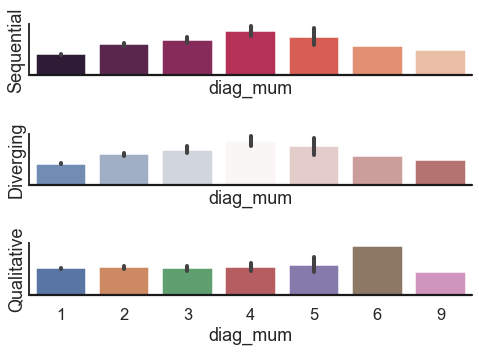

In [53]:
sns.set_theme(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

# Generate some sequential data
x = new_data2["diag_mum"]
y1 = new_data2["ElapsedTime(second)"]
sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")

# Center the data to make it diverging
y2 = y1 - 5.5
sns.barplot(x=x, y=y2, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Diverging")

# Randomly reorder the data to make it qualitative
y3 = rs.choice(y1, len(y1), replace=False)
sns.barplot(x=x, y=y3, palette="deep", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Qualitative")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

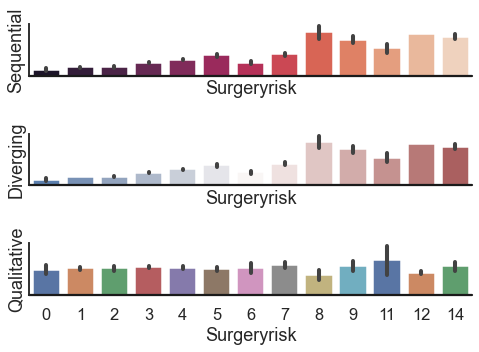

In [54]:
sns.set_theme(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

# Generate some sequential data
x = new_data2["Surgeryrisk"]
y1 = new_data2["ElapsedTime(second)"]
sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")

# Center the data to make it diverging
y2 = y1 - 5.5
sns.barplot(x=x, y=y2, palette="vlag", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Diverging")

# Randomly reorder the data to make it qualitative
y3 = rs.choice(y1, len(y1), replace=False)
sns.barplot(x=x, y=y3, palette="deep", ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Qualitative")

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

<AxesSubplot:title={'center':'distribution of the duration according to diag num'}, xlabel='diag_mum', ylabel='ElapsedTime(second)'>

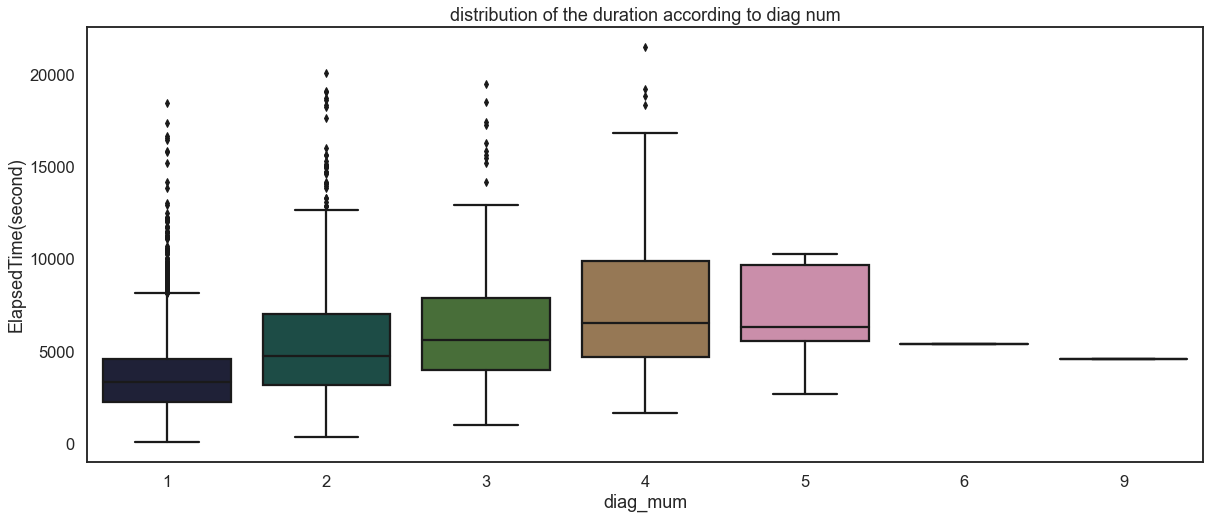

In [55]:
plt.figure(figsize=(20,8))
plt.title("distribution of the duration according to diag num")
sns.boxplot(x=new_data2["diag_mum"],y=new_data2["ElapsedTime(second)"],palette="cubehelix")

<AxesSubplot:title={'center':'distribution of the duration according to surgery risk'}, xlabel='Surgeryrisk', ylabel='ElapsedTime(second)'>

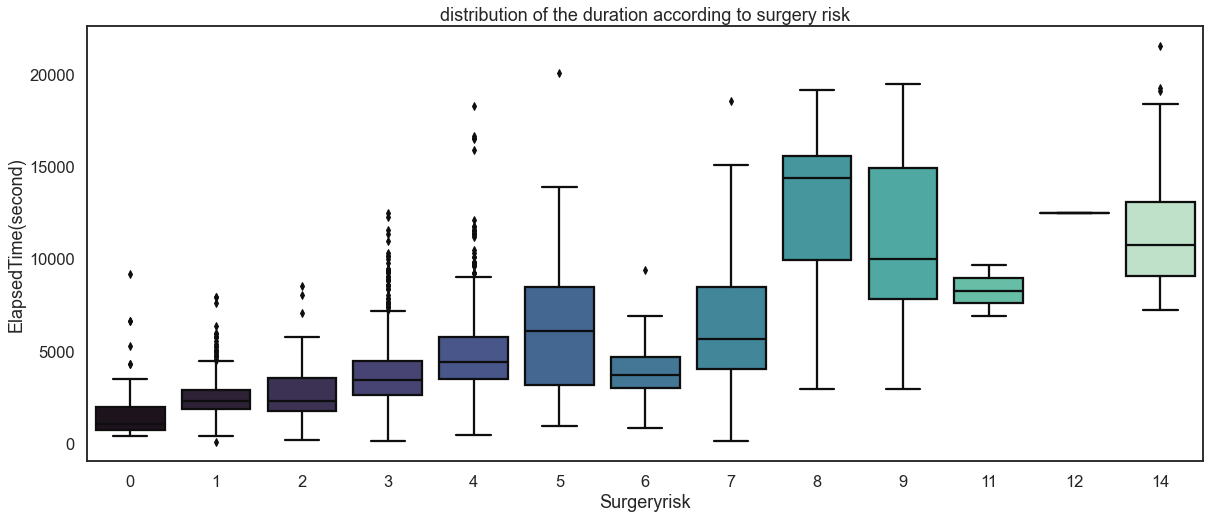

In [56]:
plt.figure(figsize=(20,8))
plt.title("distribution of the duration according to surgery risk")
sns.boxplot(x=new_data2["Surgeryrisk"],y=new_data2["ElapsedTime(second)"],palette="mako")


# Data Spliting

In [57]:
x=new_data2.drop('ElapsedTime(second)',axis=1)
y=new_data2['ElapsedTime(second)']

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

# Creating models and making prediction

In [60]:
rf=RandomForestRegressor(n_estimators=160, min_samples_leaf=14, random_state=101)

In [61]:
rf.fit(X_train,y_train)

RandomForestRegressor(min_samples_leaf=14, n_estimators=160, random_state=101)

In [62]:
rp=rf.predict(X_test)

In [63]:
from sklearn.metrics import mean_squared_error

In [64]:
np.sqrt(mean_squared_error(y_test,rp))

1686.1844909019683

In [65]:
from sklearn.model_selection import learning_curve

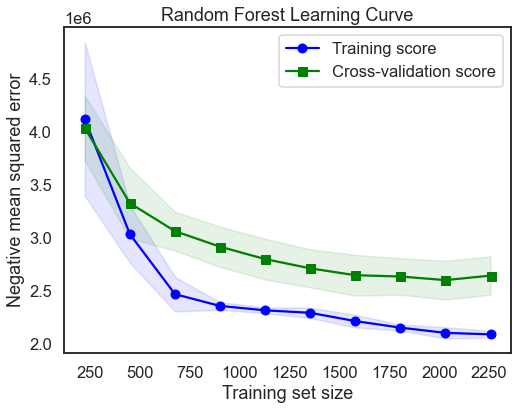

In [66]:
 train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, valid_scores = learning_curve(
    rf, x, y, train_sizes=train_sizes, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)

# Calculate the mean and standard deviation of the training and validation scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.plot(train_sizes, valid_mean, label="Cross-validation score", color="green", marker="s")
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color="green")
plt.xlabel("Training set size")
plt.ylabel("Negative mean squared error")
plt.legend(loc="best")
plt.title("Random Forest Learning Curve")
plt.show()


# Comment:- 
We have to get more data ,also We must take the opinion of experts and surgeons about the accuracy of the predection so that we have a clear idea that will help us improve the model performance.